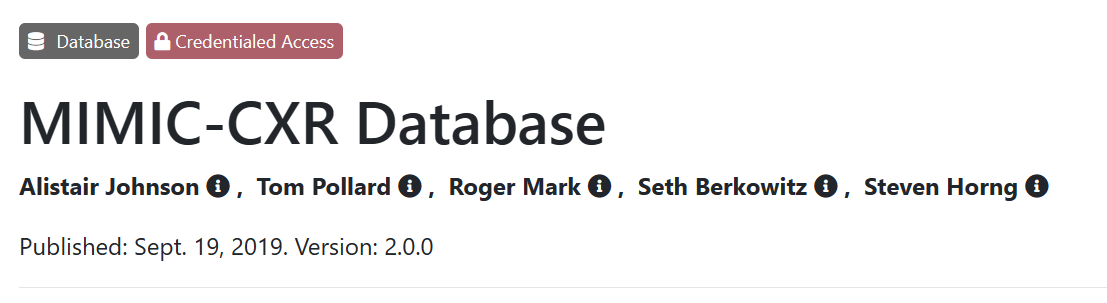

# Fine tune BERT model with MIMIC Chest XRAY report database to detect malpositioned tubes or lines on chest radiographs.

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the JSON file containing chest x-ray reports (two columns present: "File Path" and "Text")
file_path = '/content/drive/MyDrive/MIMIC/combined_df.json'
chest_xray_df = pd.read_json(file_path)

# Drop the File Path column that is not needed
chest_xray_df = chest_xray_df.drop('File Path' , axis=1)

# Add a new column 'malpositioned_line' with default value "0"
chest_xray_df['malpositioned_line'] = 0

# Display the DataFrame
print(chest_xray_df)

In [ ]:
# Define malpositioned keywords for the malpositioned_line column
malpositioned_keywords = ['malpositioned', 'malposition', 'dislodged', 'misplaced', 'incorrect placement', 'mispositioned']

# Function to check if a report contains malpositioned keywords
def check_malpositioned(report):
    for keyword in malpositioned_keywords:
        if keyword in report.lower():
            return 1
    return 0

# Update the 'malpositioned_line' column based on the check function above (0 = no malpositioned line and 1 = malpositioned line)
chest_xray_df['malpositioned_line'] = chest_xray_df['Text'].apply(check_malpositioned)

# Display the updated DataFrame
print(chest_xray_df)

In [ ]:
chest_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227835 entries, 0 to 227834
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Text                227835 non-null  object
 1   malpositioned_line  227835 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [ ]:
# Get maximum token limit for the tokenizer

from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Retrieve information about the maximum token limit
max_token_limit = tokenizer.model_max_length

# Print the maximum token limit
print("Maximum token limit:", max_token_limit)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Maximum token limit: 512


In [ ]:
# Fine Tune tinyBERT Model

# Install necessary libraries
!pip install transformers torch

# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

def preprocess_text(text):
    # Example preprocessing: converting text to lowercase
    return text.lower()

chest_xray_df['Text'] = chest_xray_df['Text'].apply(preprocess_text)

# Split the data into training and validation sets
train_data, val_data = train_test_split(chest_xray_df, test_size=0.2, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)  # binary classification

# Tokenize radiology reports
train_encodings = tokenizer(list(train_data['Text']), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(list(val_data['Text']), truncation=True, padding=True, return_tensors='pt')

# Encode labels
train_labels = torch.tensor(train_data['malpositioned_line'].values)
val_labels = torch.tensor(val_data['malpositioned_line'].values)

# Define batch size and create data loaders
batch_size = 16

train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tune the model
epochs = 3
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Must specifically set the model to "train" mode
model.train()

for epoch in range(epochs):

    total_loss = 0

    for batch in train_loader:

        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}')


# Evaluate the model on the validation set

# Must specifically set model to "evaluation" mode
model.eval()

val_accuracy = 0

with torch.no_grad():

    for batch in val_loader:

        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        #Notice the lack of labels for this outputs function (this is validation, not training - no labels needed)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        #Logits are the raw output data for the neural network before normalization or applying a activation function
        logits = outputs.logits

        #Use the ArgMax function to obtain the predicted class with highest probability
        predictions = torch.argmax(logits, dim=1)

        val_accuracy += torch.sum(predictions == labels).item()

val_accuracy /= len(val_data)
print(f'Validation Accuracy: {val_accuracy:.4f}')


In [ ]:
# Specify the directory where you want to save the model
output_dir = "/content/drive/MyDrive/MIMIC/fine_tuned_tinybert_model"

# Create the directory if it doesn't exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model and tokenizer to the specified directory
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


In [ ]:
import torch

# Define device (use GPU if available, otherwise use CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to the device
tensor = torch.tensor([1, 2, 3])
tensor = tensor.to(device)

# Identify location of saved model
output_dir = "/content/drive/MyDrive/MIMIC/fine_tuned_tinybert_model"

# Load the model and tokenizer from the saved directory
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [ ]:
# New chest radiographs to evaluate with the model

# Sample Chest X-RAY 1 (no malpositioned tube or line)

sample_chest_1 = '''

X-RAY CHEST - PA AND LATERAL VIEWS

CLINICAL HISTORY: 40 y/o male with new central line.

COMPARISON: Chest radiograph 01-12-2024

FINDINGS:

Cardiomediastinal silhouette is normal. Heart is not enlarged. Lungs are clear. No lung consolidation or large pleural effusion.

New right IJ approach central venous catheter with tip projecting over the proximal SVC. No retained guidewire. No significant pneumothorax.


IMPRESSION:

New right IJ approach central venous catheter with tip projecting over the proximal SVC. No retained guidewire. No significant pneumothorax.

'''

# Sample Chest X-RAY 2 (malpositioned tube/line present)

sample_chest_2 = '''

X-RAY CHEST - PA AND LATERAL VIEWS

CLINICAL HISTORY: 48 y/o male with new PICC. Evauate postion.

COMPARISON: Chest radiograph 03-03-2024

FINDINGS:

Cardiomediastinal silhouette is normal. Heart is not enlarged. Lungs are clear. No lung consolidation or large pleural effusion.

Left upper extremity PICC tip projects over the left neck base in the region. No retained guidewire. No significant pneumothorax.


IMPRESSION:

Malpositioned left upper extremity PICC tip projecting over left neck base.

Recommend repositioning this devise.

'''

# Sample Chest X-RAY 3

sample_chest_3 = '''

X-RAY CHEST - PA AND LATERAL VIEWS

CLINICAL HISTORY: 48 y/o male with new PICC. Evauate postion.

COMPARISON: Chest radiograph 03-03-2024

FINDINGS:

Cardiomediastinal silhouette is normal. Heart is not enlarged. Lungs are clear. No lung consolidation or large pleural effusion.

Left upper extremity PICC tip projects over the left neck base in the region. No retained guidewire. No significant pneumothorax.


IMPRESSION:

Malpositioned left upper extremity PICC tip projecting over left neck base.

Recommend repositioning this devise.

'''

print (sample_chest_2)



X-RAY CHEST - PA AND LATERAL VIEWS

CLINICAL HISTORY: 48 y/o male with new PICC. Evauate postion.

COMPARISON: Chest radiograph 03-03-2024

FINDINGS:

Cardiomediastinal silhouette is normal. Heart is not enlarged. Lungs are clear. No lung consolidation or large pleural effusion.

Left upper extremity PICC tip projects over the left neck base in the region. No retained guidewire. No significant pneumothorax.


IMPRESSION:

Malpositioned left upper extremity PICC tip projecting over left neck base.

Recommend repositioning this devise.




In [ ]:
# Use fine tunned model to evaluate unseen chest x-ray reports

# Import necessary libraries
from transformers import BertTokenizer
import torch

# Move the model to the same device as the input tensors
model.to(device)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Example radiology report
new_report = sample_chest_1

# Tokenize the input report
inputs = tokenizer(new_report, return_tensors="pt")

# Move the inputs to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Move the outputs to the CPU for post-processing
outputs = {key: value.cpu() for key, value in outputs.items()}

# Get the predicted class probabilities
logits = outputs['logits']
predictions = torch.softmax(logits, dim=1).squeeze()

# Get the predicted class (0 for non-malpositioned, 1 for malpositioned)
predicted_class = torch.argmax(predictions).item()

# Get the probability of the predicted class
predicted_probability = predictions[predicted_class].item()

# Print the result
if predicted_class == 0:
    print("The model predicts that the tubes and lines are correctly positioned.")
else:
    print("The model predicts that there is a malpositioned tube or line.")
print(f"Probability: {predicted_probability:.4f}")


The model predicts that the tubes and lines are correctly positioned.
Probability: 1.0000
